In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./BTC.csv")
# Convert Date to datetime and sort values in ascending order
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
data = data.sort_values(by='Date')

# Select only Date and Close columns for time series forecasting
data = data[['Date' , 'Close']]
print("Overview of dataset \n\n" ,data.head() )

Overview of dataset 

           Date    Close
729 2018-01-01  13535.0
728 2018-01-02  14770.0
727 2018-01-03  15057.0
726 2018-01-04  14921.0
725 2018-01-05  16828.0


In [4]:
# Extract Close price values
closing_prices = data['Close'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

In [5]:

# Create sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_data, seq_len)

In [6]:
# Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


c:\Devs\anaconda_navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,889 (148.00 KB)

 Trainable params: 37,889 (148.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0423 - val_loss: 6.3119e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0031 - val_loss: 5.2542e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0025 - val_loss: 3.0346e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0020 - val_loss: 3.2142e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0019 - val_loss: 2.7986e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0021 - val_loss: 5.3495e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0022 - val_loss: 2.9095e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0018 - val_loss: 2.8091e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0017 - val_loss: 3.0850e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0017 - val_loss: 2.6100e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0014 - val_loss: 2.5270e-04
Epoch 12/50
24/24 ━

In [9]:
# Predict and inverse transform
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y_test)

# Metrics
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual , predicted)
print(f"RMSE: {rmse}, MAE: {mae}")
print(f"R2 Score: {r2}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
RMSE: 885.826030048629, MAE: 621.7619380303524
R2 Score: 0.9573598105431131


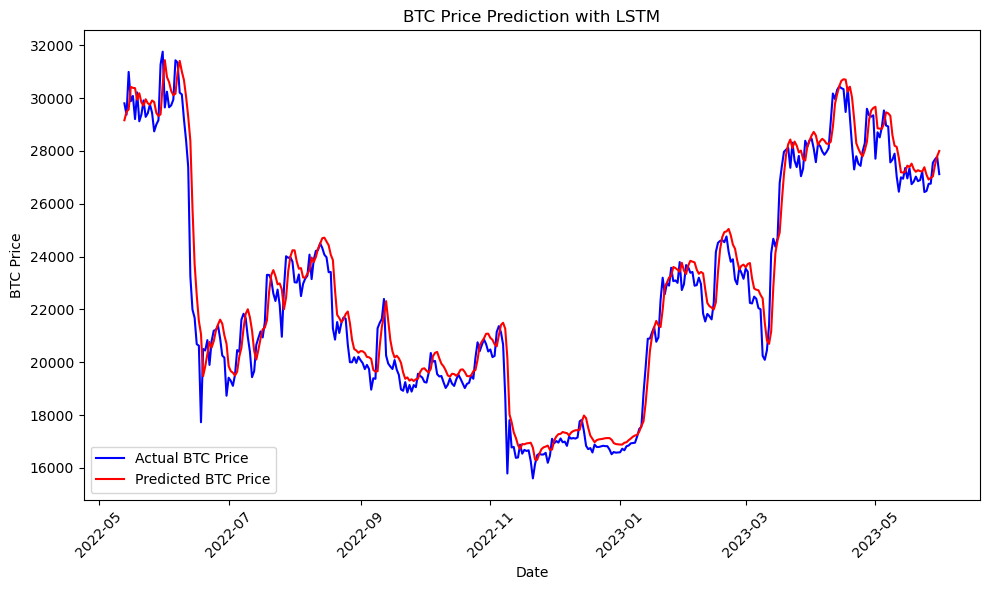

In [ ]:
import matplotlib.pyplot as plt
# Plot predicted vs. actual prices with date labels
plt.figure(figsize=(10, 6))
# Create date range for test data
test_dates = data['Date'].iloc[-len(actual):]  # Select dates for the test period
# Plot actual prices with dates
plt.plot(test_dates, actual, color='blue', label='Actual BTC Price')
# Plot predicted prices with dates
plt.plot(test_dates, predicted, color='red', label='Predicted BTC Price')
# Customize the plot
plt.title('BTC Price Prediction with GRU')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
# Rotate and format the date labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()